
0: 640x640 1 plate, 247.0ms
1: 640x640 2 plates, 247.0ms
2: 640x640 1 plate, 247.0ms
3: 640x640 1 plate, 247.0ms
4: 640x640 1 plate, 247.0ms
5: 640x640 1 plate, 247.0ms
6: 640x640 3 plates, 247.0ms
Speed: 14.8ms preprocess, 247.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test1.jpg =====


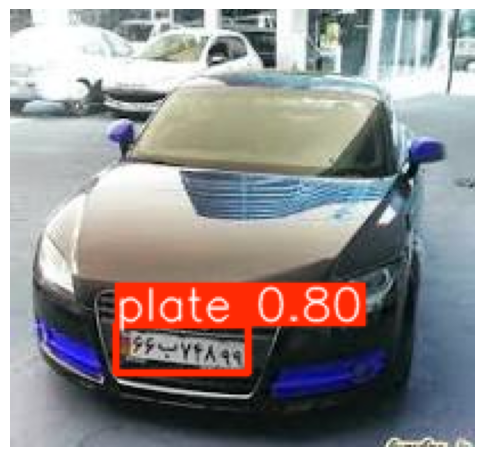

XYXY: [46, 138, 104, 159]
Confidence: 0.804050087928772
✔ Saved crop: E:\AI_PLPR_Last\PLPR\plate_crops\test1.jpg_crop0.jpg

===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test2.jpg =====


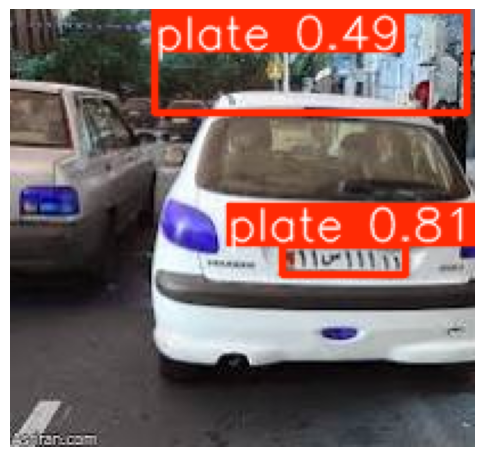

XYXY: [119, 103, 173, 116]
Confidence: 0.8148034811019897
✔ Saved crop: E:\AI_PLPR_Last\PLPR\plate_crops\test2.jpg_crop0.jpg

===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test3.jpg =====


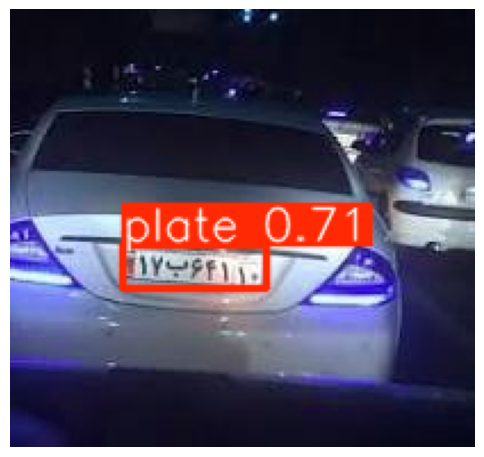

XYXY: [49, 103, 112, 122]
Confidence: 0.714314341545105
✔ Saved crop: E:\AI_PLPR_Last\PLPR\plate_crops\test3.jpg_crop0.jpg

===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test4.jpg =====


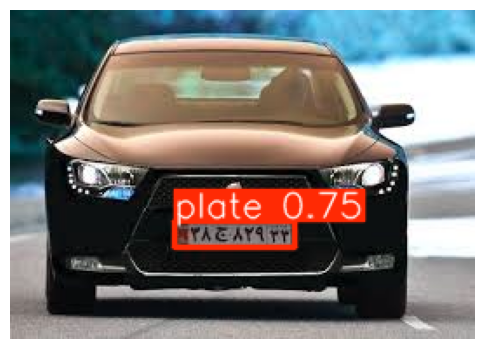

XYXY: [94, 121, 163, 136]
Confidence: 0.7459220886230469
✔ Saved crop: E:\AI_PLPR_Last\PLPR\plate_crops\test4.jpg_crop0.jpg

===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test5.jpg =====


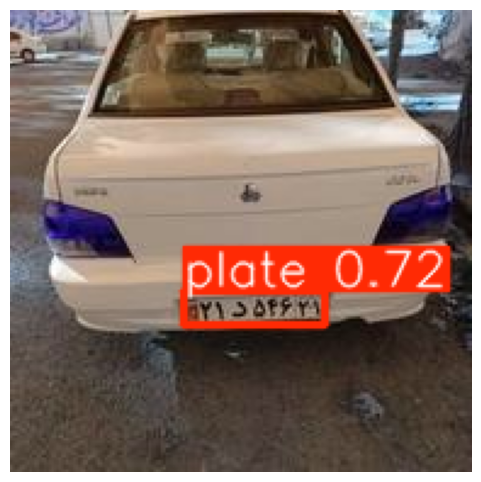

XYXY: [71, 115, 129, 129]
Confidence: 0.7177593111991882
✔ Saved crop: E:\AI_PLPR_Last\PLPR\plate_crops\test5.jpg_crop0.jpg

===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test6.jpg =====


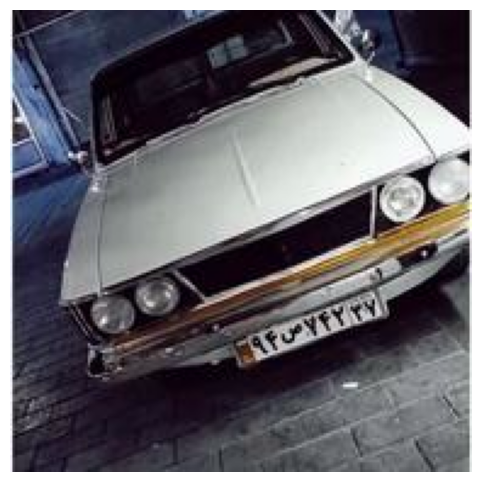


===== IMAGE: E:\AI_PLPR_Last\PLPR\photos\test7.jpg =====


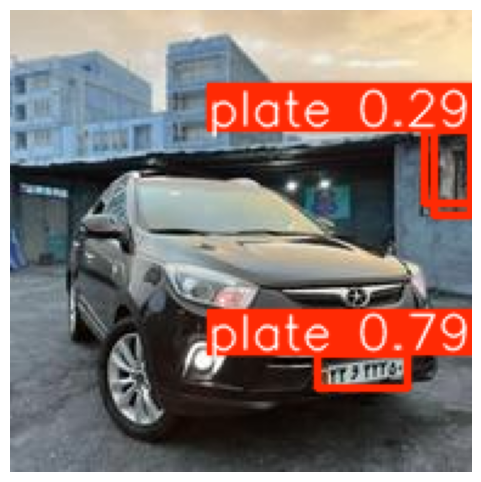

XYXY: [126, 141, 163, 155]
Confidence: 0.7920174598693848
✔ Saved crop: E:\AI_PLPR_Last\PLPR\plate_crops\test7.jpg_crop0.jpg


In [1]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

# Add the custom global class to the safe globals for deserialization
torch.serialization.add_safe_globals([ 'ultralytics.nn.tasks.DetectionModel'])

# Define the base directory
BASE_DIR = os.getcwd()

# Load the trained YOLOv11n model (best.pt)
model_path = os.path.join(BASE_DIR, 'models', 'best.pt')
model = YOLO(model_path)  # We can now safely load the custom model

# List of image paths you want to test
image_paths = [
    os.path.join(BASE_DIR, 'photos', 'test1.jpg'),
    os.path.join(BASE_DIR, 'photos', 'test2.jpg'),
    os.path.join(BASE_DIR, 'photos', 'test3.jpg'),
    os.path.join(BASE_DIR, 'photos', 'test4.jpg'),
    os.path.join(BASE_DIR, 'photos', 'test5.jpg'),
    os.path.join(BASE_DIR, 'photos', 'test6.jpg'),
    os.path.join(BASE_DIR, 'photos', 'test7.jpg'),


]

# Create a directory to save the cropped license plates
crop_dir = os.path.join(BASE_DIR, 'plate_crops')
os.makedirs(crop_dir, exist_ok=True)

# Confidence threshold (e.g., only keep boxes with confidence >= 70%)
conf_thresh = 0.70

# Run the model on the images
results = model(image_paths)

# Process each image and its results
for path, r in zip(image_paths, results):
    print(f"\n===== IMAGE: {path} =====")

    # Create a new image to plot the results on
    img = cv2.imread(path)

    # Only keep boxes with confidence >= 70%
    boxes = []
    for box in r.boxes:
        conf = float(box.conf)

        if conf >= conf_thresh:
            # Keep the box if its confidence is above the threshold
            boxes.append(box)

    # Plot the image with only the boxes with confidence >= 70%
    plt.figure(figsize=(6, 6))
    plt.imshow(r.plot(boxes=boxes))  # Plot the filtered boxes
    plt.axis("off")
    plt.show()

    crop_index = 0
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf)
        print("XYXY:", [x1, y1, x2, y2])
        print("Confidence:", conf)

        # Perform the crop (cut out the license plate area)
        crop = img[y1:y2, x1:x2]

        # Save the cropped plate image
        crop_path = os.path.join(crop_dir, f"{os.path.basename(path)}_crop{crop_index}.jpg")
        cv2.imwrite(crop_path, crop)
        print(f"✔ Saved crop: {crop_path}")

        crop_index += 1


In [25]:
import cv2
from ultralytics import YOLO
from inference_sdk import InferenceHTTPClient
from pathlib import Path
import torch
import matplotlib.pyplot as plt

# Fix for custom YOLO model loading (needed for some YOLOv11 versions)
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])

# ================= CONFIG ==================
MODEL_YOLO_PATH      = "models/best.pt"
CONF_THRESHOLD       = 0.70

ROBOFLOW_API_KEY     = "HcUxsOH12KCsbKWDuBG3"
ROBOFLOW_OCR_MODEL   = "ocr-ualje/1"
ROBOFLOW_API_URL     = "https://serverless.roboflow.com"

CROP_DIR             = Path("plate_crops")
# ============================================

# HARDCODED array of image paths (change these as you need)
PLATE_IMAGES = [
    "photos/test8.jpg",
    # "photos/test2.jpg",
    # "photos/plate_iran_2025_001.jpg",
    # "photos/car_front_27dec.jpg",
    # "photos/plate_sample_3.png",
    # Add / remove / change paths here
    # You can use relative or absolute paths:
    # r"C:\Users\You\Downloads\plate_new.jpg",
    # "/home/user/pictures/iran_plate_test4.jpg",
]


def init_roboflow_client():
    try:
        return InferenceHTTPClient(
            api_url=ROBOFLOW_API_URL,
            api_key=ROBOFLOW_API_KEY
        )
    except Exception as e:
        print(f"Roboflow client failed to initialize: {e}")
        return None


def run_ocr_on_crop(client, crop_path: Path):
    if not client:
        return None, "OCR client not available"

    try:
        result = client.infer(str(crop_path), model_id=ROBOFLOW_OCR_MODEL)
        preds = result.get('predictions', []) or getattr(result, 'predictions', [])

        if not preds:
            return None, "No characters detected"

        # Sort right-to-left + top-to-bottom for Persian license plates
        sorted_preds = sorted(preds, key=lambda p: (-p['y'], p['x']))
        text = ''.join(p.get('class', p.get('text', '')) for p in sorted_preds)

        return text.strip(), f"{len(preds)} chars"

    except Exception as e:
        return None, f"OCR error: {str(e)}"


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES array!")
        return

    print(f"Processing {len(PLATE_IMAGES)} hardcoded images...\n")

    model = YOLO(str(Path.cwd() / MODEL_YOLO_PATH))
    ocr_client = init_roboflow_client()

    for img_path_str in PLATE_IMAGES:
        img_path = Path(img_path_str)

        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue

        print(f"\n===== {img_path.name} =====")

        # YOLO detection
        results = model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))

        if img is None:
            print("  Cannot read image")
            continue

        good_boxes = [b for b in results.boxes if float(b.conf) >= CONF_THRESHOLD]

        if not good_boxes:
            print("  No license plates detected above threshold")
            continue

        # Optional: Show detection result
        annotated = cv2.cvtColor(results.plot(boxes=good_boxes), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(annotated)
        plt.axis('off')
        plt.title(f"{img_path.name} — {len(good_boxes)} plates")
        plt.show()

        # Crop + OCR each plate
        stem = img_path.stem
        for i, box in enumerate(good_boxes, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = img[y1:y2, x1:x2]

            if crop.shape[0] < 30 or crop.shape[1] < 80:
                print(f"  Plate {i} too small → skipped")
                continue

            crop_name = f"{stem}_plate{i}_c{int(box.conf*100)}.jpg"
            crop_path = CROP_DIR / crop_name
            cv2.imwrite(str(crop_path), crop)
            print(f"  Saved crop: {crop_name}")

            # Run OCR
            text, info = run_ocr_on_crop(ocr_client, crop_path)
            if text:
                print(f"  OCR: {text}  ({info})")
                # Optional: rename file with recognized text
                try:
                    new_path = CROP_DIR / f"{stem}_plate{i}_{text.replace(' ', '')}.jpg"
                    crop_path.rename(new_path)
                    print(f"     → Renamed with text")
                except Exception:
                    pass
            else:
                print(f"  OCR failed: {info}")


if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [16]:
# import os
# from pathlib import Path
# import cv2
# import torch
# from ultralytics import YOLO
# from inference_sdk import InferenceHTTPClient
# import matplotlib.pyplot as plt
#
# # Fix for YOLO custom model loading
# torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])
#
# # ================== CONFIG ==================
# MODEL_YOLO_PATH      = "models/best.pt"                 # Your local YOLOv11 plate detector
# CONF_THRESHOLD       = 0.70                             # For YOLO detection
#
# # Roboflow OCR (Iranian/Persian license plate)
# ROBOFLOW_API_KEY     = "HcUxsOH12KCsbKWDuBG3"           # ← Your key
# ROBOFLOW_OCR_MODEL   = "ocr-ualje/1"                    # Iranian OCR model
# ROBOFLOW_API_URL     = "https://serverless.roboflow.com"
#
# PHOTOS_DIR           = "photos"
# CROP_DIR             = "plate_crops"
# IMAGE_EXTENSIONS     = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}
# # ============================================
#
# def init_roboflow_client():
#     """Initialize Roboflow Inference client once"""
#     try:
#         client = InferenceHTTPClient(
#             api_url=ROBOFLOW_API_URL,
#             api_key=ROBOFLOW_API_KEY
#         )
#         print("Roboflow OCR client initialized successfully ✓")
#         return client
#     except Exception as e:
#         print(f"Failed to initialize Roboflow client: {e}")
#         return None
#
#
# def run_ocr_on_crop(client, crop_img_path: Path):
#     """Run Persian OCR using Roboflow hosted API"""
#     if not client:
#         return None, "OCR client not available"
#
#     try:
#         # infer() accepts path (str) or numpy array
#         result = client.infer(
#             str(crop_img_path),
#             model_id=ROBOFLOW_OCR_MODEL
#         )
#
#         # Typical structure: result.get('predictions', []) or result.predictions
#         predictions = result.get('predictions', []) or getattr(result, 'predictions', [])
#
#         if not predictions:
#             return None, "No text detected"
#
#         # Most OCR models return list of dicts with 'class'/'text' or similar
#         # We take the most confident or join them (depends on your model)
#         texts = [pred.get('class', pred.get('text', '')) for pred in predictions]
#         full_text = " ".join(filter(None, texts))
#
#         return full_text.strip(), f"{len(predictions)} chars"
#
#     except Exception as e:
#         return None, f"OCR error: {str(e)}"
#
#
# def main():
#     base_dir = Path.cwd()
#     yolo_path = base_dir / MODEL_YOLO_PATH
#     photos_dir = base_dir / PHOTOS_DIR
#     crop_dir = base_dir / CROP_DIR
#
#     crop_dir.mkdir(parents=True, exist_ok=True)
#
#     if not yolo_path.is_file():
#         print(f"YOLO model not found → {yolo_path}")
#         return
#
#     print(f"Loading YOLO model: {yolo_path.name}")
#     model = YOLO(str(yolo_path))
#
#     # Initialize OCR client
#     ocr_client = init_roboflow_client()
#
#     # Get all images
#     image_paths = sorted(p for p in photos_dir.iterdir()
#                         if p.is_file() and p.suffix.lower() in IMAGE_EXTENSIONS)
#
#     if not image_paths:
#         print(f"No images found in {photos_dir}")
#         return
#
#     print(f"Found {len(image_paths)} images\n")
#
#     for img_path in image_paths:
#         print(f"\n===== {img_path.name} =====")
#
#         # Run YOLO detection
#         results = model(img_path, verbose=False)[0]
#
#         img_bgr = cv2.imread(str(img_path))
#         if img_bgr is None:
#             print("  → Cannot read image")
#             continue
#
#         # Filter good detections
#         good_boxes = [box for box in results.boxes if float(box.conf) >= CONF_THRESHOLD]
#
#         if not good_boxes:
#             print("  → No license plates detected above threshold")
#             continue
#
#         # Show result
#         annotated = results.plot(boxes=good_boxes)
#         annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
#
#         plt.figure(figsize=(9, 7))
#         plt.title(f"{img_path.name} — {len(good_boxes)} plates found")
#         plt.imshow(annotated_rgb)
#         plt.axis("off")
#         plt.tight_layout()
#         plt.show()
#
#         # Process each plate
#         stem = img_path.stem
#         for i, box in enumerate(good_boxes, 1):
#             x1, y1, x2, y2 = map(int, box.xyxy[0])
#             conf = float(box.conf)
#
#             crop = img_bgr[y1:y2, x1:x2]
#             if crop.size == 0 or crop.shape[0] < 30 or crop.shape[1] < 80:
#                 print(f"  → Plate {i} too small, skipped")
#                 continue
#
#             crop_filename = f"{stem}_plate{i}_conf{conf:.2f}.jpg"
#             crop_path = crop_dir / crop_filename
#             cv2.imwrite(str(crop_path), crop)
#             print(f"  Saved crop: {crop_filename}")
#
#             # OCR step
#             if ocr_client:
#                 text, info = run_ocr_on_crop(ocr_client, crop_path)
#                 if text:
#                     print(f"  OCR result: {text}   ({info})")
#                     # Optional: rename with text (be careful with special chars)
#                     new_name = f"{stem}_plate{i}_conf{conf:.2f}_{text.replace(' ', '_')}.jpg"
#                     new_path = crop_dir / new_name
#                     try:
#                         crop_path.rename(new_path)
#                         print(f"    → Renamed with text: {new_name}")
#                     except:
#                         pass  # filename might be invalid
#                 else:
#                     print(f"  OCR failed: {info}")
#             else:
#                 print("  → Skipping OCR (client not initialized)")
#
#     print("\nAll done! Check the 'plate_crops' folder.")
#
#
# if __name__ == "__main__":
#     main()

Processing 1 hardcoded images...


===== test8.jpg =====


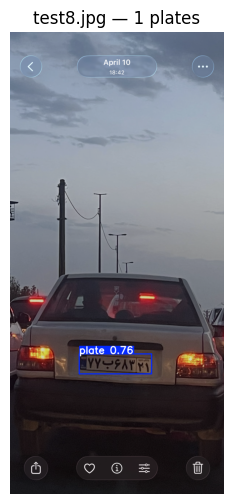

  Saved crop: test8_plate1_c75.jpg
  OCR failed: OCR error: HTTPSConnectionPool(host='serverless.roboflow.com', port=443): Max retries exceeded with url: /ocr-ualje/1?api_key=HcUxsOH12KCsbKWDuBG3&disable_active_learning=False (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))


In [20]:
import cv2
from ultralytics import YOLO
from inference_sdk import InferenceHTTPClient
from pathlib import Path
import torch
import matplotlib.pyplot as plt

# Fix for custom YOLO model loading (needed for some YOLOv11 versions)
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])

# ================= CONFIG ==================
MODEL_YOLO_PATH      = "models/best.pt"
CONF_THRESHOLD       = 0.70

ROBOFLOW_API_KEY     = "HcUxsOH12KCsbKWDuBG3"
ROBOFLOW_OCR_MODEL   = "ocr-ualje/1"
ROBOFLOW_API_URL     = "https://serverless.roboflow.com"

CROP_DIR             = Path("plate_crops")
# ============================================

# HARDCODED array of image paths (change these as you need)
PLATE_IMAGES = [
    "photos/test8.jpg",
    # "photos/test2.jpg",
    # "photos/plate_iran_2025_001.jpg",
    # "photos/car_front_27dec.jpg",
    # "photos/plate_sample_3.png",
    # Add / remove / change paths here
    # You can use relative or absolute paths:
    # r"C:\Users\You\Downloads\plate_new.jpg",
    # "/home/user/pictures/iran_plate_test4.jpg",
]


def init_roboflow_client():
    try:
        return InferenceHTTPClient(
            api_url=ROBOFLOW_API_URL,
            api_key=ROBOFLOW_API_KEY
        )
    except Exception as e:
        print(f"Roboflow client failed to initialize: {e}")
        return None


from collections import defaultdict
from collections import defaultdict

def run_ocr_on_crop(client, crop_path: Path):
    if not client:
        return None, "OCR client not available"

    try:
        result = client.infer(str(crop_path), model_id=ROBOFLOW_OCR_MODEL)
        preds = result.get('predictions', []) or getattr(result, 'predictions', [])

        if not preds:
            return None, "No characters detected"

        # Debug prints (very helpful!)
        print("\nRaw detections:", [p.get('class', '?') for p in preds])
        print("x:", [round(p['x']) for p in preds])
        print("y:", [round(p['y']) for p in preds])

        # Larger tolerance → treat almost everything as one line
        LINE_TOLERANCE_PX = 25          # ← increase if still multiple lines
        rows = defaultdict(list)

        for p in preds:
            y = p['y']
            assigned = False
            for row_y in list(rows):
                if abs(y - row_y) < LINE_TOLERANCE_PX:
                    rows[row_y].append(p)
                    assigned = True
                    break
            if not assigned:
                rows[y] = [p]

        sorted_row_ys = sorted(rows.keys())  # top → bottom

        full_text_parts = []
        for row_y in sorted_row_ys:
            row = rows[row_y]
            # LEFT-TO-RIGHT this time!
            row_sorted = sorted(row, key=lambda p: p['x'])  # ← change reverse=True → False
            row_text = ''.join(p.get('class', p.get('text', '')) for p in row_sorted)
            if row_text:
                full_text_parts.append(row_text)

        full_text = ' '.join(full_text_parts) if len(full_text_parts) > 1 else full_text_parts[0]

        return full_text.strip(), f"{len(preds)} chars • {len(full_text_parts)} line(s)"

    except Exception as e:
        return None, f"OCR error: {str(e)}"# def run_ocr_on_crop(client, crop_path: Path):
#     """
#     Robust OCR sorting for Iranian/Persian plates:
#     - Groups characters into lines using y-coordinate tolerance
#     - Sorts lines top → bottom
#     - Within each line: right → left (decreasing x)
#     - Handles center coordinates (most common in Roboflow OCR models)
#     """
#     if not client:
#         return None, "OCR client not available"
#
#     try:
#         result = client.infer(str(crop_path), model_id=ROBOFLOW_OCR_MODEL)
#
#         preds = result.get('predictions', []) or getattr(result, 'predictions', [])
#
#         if not preds:
#             return None, "No characters detected"
#
#         # ── Parameters ───────────────────────────────────────
#         LINE_TOLERANCE = 0.08     # 8% of image height tolerance for same line
#         # You can also use fixed pixels: LINE_TOLERANCE_PX = 12
#
#         # ── 1. Group characters by approximate horizontal line ──
#         rows = defaultdict(list)
#
#         # Use image height to make tolerance scale-invariant (recommended)
#         # If you don't have height, use fixed pixel value
#         img_height = result.get('image', {}).get('height', 100)  # fallback
#
#         tolerance = img_height * LINE_TOLERANCE
#
#         for p in preds:
#             y_center = p['y']  # assuming center y (most common)
#             assigned = False
#
#             # Find existing row with close y
#             for row_y in list(rows.keys()):
#                 if abs(y_center - row_y) < tolerance:
#                     rows[row_y].append(p)
#                     assigned = True
#                     break
#
#             if not assigned:
#                 rows[y_center] = [p]
#
#         # ── 2. Sort rows top to bottom (increasing y) ────────
#         sorted_row_ys = sorted(rows.keys())
#
#         # ── 3. For each row: sort right → left (decreasing x) ─
#         full_text_parts = []
#
#         for row_y in sorted_row_ys:
#             row_preds = rows[row_y]
#             # Sort by x descending → right to left
#             row_sorted = sorted(row_preds, key=lambda p: p['x'], reverse=True)
#
#             # Join characters (no spaces for license plate)
#             row_text = ''.join(
#                 p.get('class', p.get('text', p.get('prediction', '')))
#                 for p in row_sorted
#             ).strip()
#
#             if row_text:
#                 full_text_parts.append(row_text)
#
#         # Join lines (usually just one line, but handles multi-line plates)
#         full_text = ' '.join(full_text_parts) if len(full_text_parts) > 1 else full_text_parts[0]
#
#         info = f"{len(preds)} chars • {len(full_text_parts)} line(s)"
#
#         # Debug: uncomment to see raw order vs sorted
#         # print("Raw preds order:", [p.get('class') for p in preds])
#         # print("Sorted text:", full_text)
#
#         return full_text, info
#
#     except Exception as e:
#         return None, f"OCR error: {str(e)}"

def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES array!")
        return

    print(f"Processing {len(PLATE_IMAGES)} hardcoded images...\n")

    model = YOLO(str(Path.cwd() / MODEL_YOLO_PATH))
    ocr_client = init_roboflow_client()

    for img_path_str in PLATE_IMAGES:
        img_path = Path(img_path_str)

        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue

        print(f"\n===== {img_path.name} =====")

        # YOLO detection
        results = model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))

        if img is None:
            print("  Cannot read image")
            continue

        good_boxes = [b for b in results.boxes if float(b.conf) >= CONF_THRESHOLD]

        if not good_boxes:
            print("  No license plates detected above threshold")
            continue

        # Optional: Show detection result
        annotated = cv2.cvtColor(results.plot(boxes=good_boxes), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(annotated)
        plt.axis('off')
        plt.title(f"{img_path.name} — {len(good_boxes)} plates")
        plt.show()

        # Crop + OCR each plate
        stem = img_path.stem
        for i, box in enumerate(good_boxes, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = img[y1:y2, x1:x2]

            if crop.shape[0] < 30 or crop.shape[1] < 80:
                print(f"  Plate {i} too small → skipped")
                continue

            crop_name = f"{stem}_plate{i}_c{int(box.conf*100)}.jpg"
            crop_path = CROP_DIR / crop_name
            cv2.imwrite(str(crop_path), crop)
            print(f"  Saved crop: {crop_name}")

            # Run OCR
            text, info = run_ocr_on_crop(ocr_client, crop_path)
            if text:
                print(f"  OCR: {text}  ({info})")
                # Optional: rename file with recognized text
                try:
                    new_path = CROP_DIR / f"{stem}_plate{i}_{text.replace(' ', '')}.jpg"
                    crop_path.rename(new_path)
                    print(f"     → Renamed with text")
                except Exception:
                    pass
            else:
                print(f"  OCR failed: {info}")


if __name__ == "__main__":
    main()

Processing 1 images...


===== test8.jpg =====


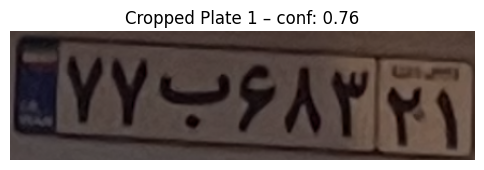

  Saved & shown crop: test8_plate1_conf0.76.jpg
  OCR failed: OCR error: HTTPSConnectionPool(host='serverless.roboflow.com', port=443): Max retries exceeded with url: /ocr-ualje/1?api_key=HcUxsOH12KCsbKWDuBG3&disable_active_learning=False (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))

Processing finished!


In [19]:
import cv2
from ultralytics import YOLO
from inference_sdk import InferenceHTTPClient
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Fix for custom model loading
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])

# ================= CONFIG ==================
MODEL_YOLO_PATH      = "models/best.pt"
CONF_THRESHOLD       = 0.70

ROBOFLOW_API_KEY     = "HcUxsOH12KCsbKWDuBG3"
ROBOFLOW_OCR_MODEL   = "ocr-ualje/1"
ROBOFLOW_API_URL     = "https://serverless.roboflow.com"

CROP_DIR             = Path("plate_crops")

# HARDCODED images (add more as needed)
PLATE_IMAGES = [
    "photos/test8.jpg",
    # "photos/test2.jpg",
    # ...
]
# ============================================


def init_roboflow_client():
    try:
        return InferenceHTTPClient(
            api_url=ROBOFLOW_API_URL,
            api_key=ROBOFLOW_API_KEY
        )
    except Exception as e:
        print(f"Roboflow client failed: {e}")
        return None


def run_ocr_on_crop(client, crop_path: Path):
    if not client:
        return None, "No OCR client"

    try:
        result = client.infer(str(crop_path), model_id=ROBOFLOW_OCR_MODEL)
        preds = result.get('predictions', []) or getattr(result, 'predictions', [])

        if not preds:
            return None, "No characters detected"

        # Group by rows (tolerance-based)
        rows = defaultdict(list)
        LINE_TOLERANCE_PX = 25

        for p in preds:
            y = p['y']
            assigned = False
            for row_y in list(rows.keys()):
                if abs(y - row_y) < LINE_TOLERANCE_PX:
                    rows[row_y].append(p)
                    assigned = True
                    break
            if not assigned:
                rows[y] = [p]

        # Sort rows top → bottom
        sorted_rows = sorted(rows.keys())

        text_parts = []
        for row_y in sorted_rows:
            # Sort left-to-right (you can change to reverse=True for right-to-left)
            row_sorted = sorted(rows[row_y], key=lambda p: p['x'])
            row_text = ''.join(p.get('class', p.get('text', '')) for p in row_sorted)
            if row_text:
                text_parts.append(row_text)

        full_text = ' '.join(text_parts) if len(text_parts) > 1 else text_parts[0]

        return full_text.strip(), f"{len(preds)} chars • {len(text_parts)} line(s)"

    except Exception as e:
        return None, f"OCR error: {str(e)}"


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES!")
        return

    print(f"Processing {len(PLATE_IMAGES)} images...\n")

    model = YOLO(str(Path.cwd() / MODEL_YOLO_PATH))
    ocr_client = init_roboflow_client()

    for img_path_str in PLATE_IMAGES:
        img_path = Path(img_path_str)
        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue

        print(f"\n===== {img_path.name} =====")

        # Run detection
        results = model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))
        if img is None:
            print("Cannot read image")
            continue

        good_boxes = [b for b in results.boxes if float(b.conf) >= CONF_THRESHOLD]

        if not good_boxes:
            print("No plates detected above threshold")
            continue

        stem = img_path.stem

        # Process each detected plate
        for i, box in enumerate(good_boxes, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 30 or crop.shape[1] < 80:
                print(f"Plate {i} too small → skipped")
                continue

            # 1. Save crop
            crop_name = f"{stem}_plate{i}_conf{conf:.2f}.jpg"
            crop_path = CROP_DIR / crop_name
            cv2.imwrite(str(crop_path), crop)

            # 2. Show the cropped plate photo
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6, 4))
            plt.imshow(crop_rgb)
            plt.axis('off')
            plt.title(f"Cropped Plate {i} – conf: {conf:.2f}")
            plt.show()

            print(f"  Saved & shown crop: {crop_name}")

            # 3. Run OCR
            text, info = run_ocr_on_crop(ocr_client, crop_path)
            if text:
                print(f"  OCR result: {text}")
                print(f"  ({info})")

                # Optional: rename with OCR text
                try:
                    new_name = f"{stem}_plate{i}_{text.replace(' ', '_')}.jpg"
                    new_path = CROP_DIR / new_name
                    crop_path.rename(new_path)
                    print(f"     → Renamed to: {new_name}")
                except Exception:
                    pass
            else:
                print(f"  OCR failed: {info}")

    print("\nProcessing finished!")


if __name__ == "__main__":
    main()

Loading local model: C:\Users\Arshia\PycharmProjects\PLPR\models\best.pt
Processing 1 images...


===== Processing: test8.jpg =====


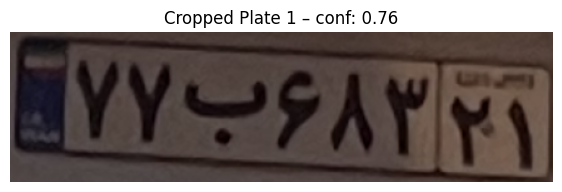

  Saved & shown: test8_plate1_conf0.76.jpg
  OCR result: plate
  (1 characters detected)
     → Renamed: test8_plate1_plate.jpg

All done!


In [5]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# Fix for custom model loading (if using YOLOv11 or custom trained model)
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])
BASE_DIR = os.getcwd()

# Load the trained YOLOv11n model (best.pt)
# model_path = os.path.join(BASE_DIR, 'models', 'best.pt')
# ================= CONFIG ==================
PLATE_MODEL_PATH     = os.path.join(BASE_DIR, 'models', 'best.pt')            # ← your trained character detection model
CONF_THRESHOLD       = 0.50                    # lower for characters (they are small)
CROP_DIR             = Path("plate_crops")

# HARDCODED array of full car images
PLATE_IMAGES = [
    "photos/test8.jpg",
    # "photos/test2.jpg",
    # ...
]
# ============================================


def detect_and_recognize_plate(model, img_path: Path):
    """Detect plate → crop → detect characters → read text"""
    print(f"\n===== Processing: {img_path.name} =====")

    # Run plate detection
    results = model(img_path, verbose=False)[0]
    img = cv2.imread(str(img_path))
    if img is None:
        print("Cannot read image")
        return

    # Filter good plate boxes
    good_plates = [box for box in results.boxes if float(box.conf) >= CONF_THRESHOLD]

    if not good_plates:
        print("No license plates detected above threshold")
        return

    stem = img_path.stem

    for i, plate_box in enumerate(good_plates, 1):
        x1, y1, x2, y2 = map(int, plate_box.xyxy[0])
        conf = float(plate_box.conf)

        # Crop the plate
        crop = img[y1:y2, x1:x2]
        if crop.shape[0] < 30 or crop.shape[1] < 80:
            print(f"  Plate {i} too small → skipped")
            continue

        # 1. Save and SHOW the cropped plate
        crop_name = f"{stem}_plate{i}_conf{conf:.2f}.jpg"
        crop_path = CROP_DIR / crop_name
        cv2.imwrite(str(crop_path), crop)

        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7, 4))
        plt.imshow(crop_rgb)
        plt.axis('off')
        plt.title(f"Cropped Plate {i} – conf: {conf:.2f}")
        plt.show()

        print(f"  Saved & shown: {crop_name}")

        # 2. Run character detection + OCR on the crop
        char_results = model(crop_path, verbose=False)[0]  # same model for characters

        chars = []
        for box in char_results.boxes:
            if float(box.conf) < 0.4:  # stricter for characters
                continue
            cls_id = int(box.cls)
            cls_name = model.names[cls_id]  # Persian letter/digit name
            chars.append((box.xyxy[0], cls_name, float(box.conf)))

        if not chars:
            print("  No characters detected")
            continue

        # 3. Sort characters (group by lines + left-to-right or right-to-left)
        rows = defaultdict(list)
        LINE_TOLERANCE_PX = 25

        for xyxy, cls_name, conf in chars:
            _, y1, _, y2 = map(int, xyxy)
            y_center = (y1 + y2) / 2
            assigned = False
            for row_y in list(rows):
                if abs(y_center - row_y) < LINE_TOLERANCE_PX:
                    rows[row_y].append((xyxy, cls_name, conf))
                    assigned = True
                    break
            if not assigned:
                rows[y_center] = [(xyxy, cls_name, conf)]

        sorted_rows = sorted(rows.keys())  # top → bottom

        text_parts = []
        for row_y in sorted_rows:
            # Change reverse=True → False for left-to-right
            # Change to reverse=True for right-to-left (Persian reading order)
            row_sorted = sorted(rows[row_y], key=lambda t: t[0][0], reverse=False)
            row_text = ''.join(t[1] for t in row_sorted)
            if row_text:
                text_parts.append(row_text)

        full_text = ' '.join(text_parts) if len(text_parts) > 1 else text_parts[0]

        print(f"  OCR result: {full_text}")
        print(f"  ({len(chars)} characters detected)")

        # Optional: rename crop with recognized text
        try:
            new_name = f"{stem}_plate{i}_{full_text.replace(' ', '_')}.jpg"
            new_path = CROP_DIR / new_name
            crop_path.rename(new_path)
            print(f"     → Renamed: {new_name}")
        except Exception:
            pass


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES!")
        return

    print(f"Loading local model: {PLATE_MODEL_PATH}")
    model = YOLO(PLATE_MODEL_PATH)

    print(f"Processing {len(PLATE_IMAGES)} images...\n")

    for img_str in PLATE_IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue
        detect_and_recognize_plate(model, img_path)

    print("\nAll done!")


if __name__ == "__main__":
    main()

Loading models...
Models loaded successfully

Processing 9 images...


===== Processing: test8.jpg =====


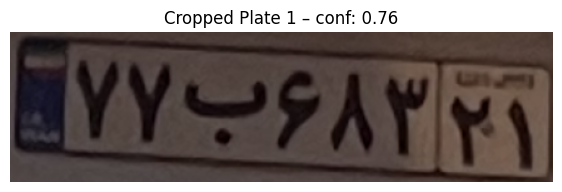

  Saved & displayed: test8_plate1_conf0.76.jpg
  OCR result: sevensevenBsixeightthreetwotwo one
  (9 characters detected)

===== Processing: test10.jpg =====
  Plate 1 too small → skipped

===== Processing: test11.jpg =====
  Plate 1 too small → skipped

===== Processing: test12.jpg =====
  Plate 1 too small → skipped

===== Processing: test13.jpg =====
  Plate 1 too small → skipped
File not found → photos\test14.jpg

===== Processing: test15.jpg =====


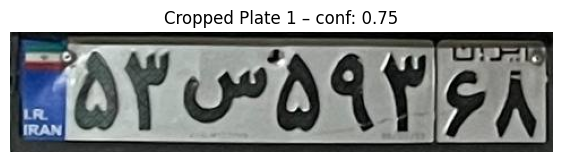

  Saved & displayed: test15_plate1_conf0.75.jpg
  OCR result: fiveJanbazfivethreesixeight
  (6 characters detected)
     → Renamed to: test15_plate1_fiveJanbazfivethreesixeight.jpg

===== Processing: test16.jpg =====
  Plate 1 too small → skipped

===== Processing: test17.jpg =====


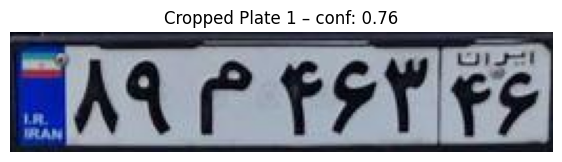

  Saved & displayed: test17_plate1_conf0.76.jpg
  OCR result: eightMfoursixthreefoursix
  (7 characters detected)
     → Renamed to: test17_plate1_eightMfoursixthreefoursix.jpg

All processing finished!


In [2]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Fix for potential custom model loading issues
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])

# ================= CONFIG ==================
PLATE_DETECTOR_PATH  = "models/best.pt"          # Your plate detector
CHAR_OCR_PATH        = "models/plate.pt"         # Your character OCR model
CONF_THRESHOLD_PLATE = 0.70
CONF_THRESHOLD_CHAR  = 0.45                      # usually lower for small characters

CROP_DIR             = Path("plate_crops")

# HARDCODED images to process
PLATE_IMAGES = [
    "photos/test8.jpg",

    # "photos/test8.jpg",
    "photos/test10.jpg",
    "photos/test11.jpg",
    "photos/test12.jpg",
    "photos/test13.jpg",
    "photos/test14.jpg",
    "photos/test15.jpg",
    "photos/test16.jpg",
    "photos/test17.jpg",


]
# ============================================


def load_models():
    print("Loading models...")
    plate_model = YOLO(PLATE_DETECTOR_PATH)
    char_model = YOLO(CHAR_OCR_PATH)
    print("Models loaded successfully\n")
    return plate_model, char_model


def process_image(plate_model, char_model, img_path: Path):
    print(f"\n===== Processing: {img_path.name} =====")

    # 1. Detect license plates
    results = plate_model(img_path, verbose=False)[0]
    img = cv2.imread(str(img_path))
    if img is None:
        print("Cannot read image")
        return

    good_plates = [b for b in results.boxes if float(b.conf) >= CONF_THRESHOLD_PLATE]

    if not good_plates:
        print("No license plates detected above threshold")
        return

    stem = img_path.stem

    for i, plate_box in enumerate(good_plates, 1):
        x1, y1, x2, y2 = map(int, plate_box.xyxy[0])
        conf = float(plate_box.conf)

        # Crop the plate
        crop = img[y1:y2, x1:x2]
        if crop.shape[0] < 30 or crop.shape[1] < 80:
            print(f"  Plate {i} too small → skipped")
            continue

        # 1. Save & SHOW cropped plate
        crop_name = f"{stem}_plate{i}_conf{conf:.2f}.jpg"
        crop_path = CROP_DIR / crop_name
        cv2.imwrite(str(crop_path), crop)

        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7, 4))
        plt.imshow(crop_rgb)
        plt.axis('off')
        plt.title(f"Cropped Plate {i} – conf: {conf:.2f}")
        plt.show()

        print(f"  Saved & displayed: {crop_name}")

        # 2. Character detection (OCR) on the cropped plate
        char_results = char_model(crop_path, verbose=False)[0]

        characters = []
        for box in char_results.boxes:
            char_conf = float(box.conf)
            if char_conf < CONF_THRESHOLD_CHAR:
                continue

            cls_id = int(box.cls)
            char_name = char_model.names[cls_id]  # e.g. 'alef', '1', 'ب', etc.
            characters.append((box.xyxy[0], char_name, char_conf))

        if not characters:
            print("  No characters detected")
            continue

        # 3. Group characters by approximate line + sort
        rows = defaultdict(list)
        LINE_TOLERANCE_PX = 25  # adjust based on your plate height

        for xyxy, char_name, conf in characters:
            x1c, y1c, x2c, y2c = map(int, xyxy)
            y_center = (y1c + y2c) / 2
            assigned = False
            for row_y in list(rows.keys()):
                if abs(y_center - row_y) < LINE_TOLERANCE_PX:
                    rows[row_y].append((xyxy, char_name, conf))
                    assigned = True
                    break
            if not assigned:
                rows[y_center] = [(xyxy, char_name, conf)]

        # Sort rows top to bottom
        sorted_rows = sorted(rows.keys())

        text_parts = []
        for row_y in sorted_rows:
            # Change reverse=True → False for left-to-right
            # Change to reverse=True for right-to-left (Persian reading order)
            row_sorted = sorted(rows[row_y], key=lambda t: t[0][0], reverse=False)
            row_text = ''.join(t[1] for t in row_sorted)
            if row_text:
                text_parts.append(row_text)

        full_text = ' '.join(text_parts) if len(text_parts) > 1 else text_parts[0]

        print(f"  OCR result: {full_text }")
        print(f"  ({len(characters)} characters detected)")

        # Optional: rename file with recognized text
        try:
            new_name = f"{stem}_plate{i}_{full_text.replace(' ', '_')}.jpg"
            new_path = CROP_DIR / new_name
            crop_path.rename(new_path)
            print(f"     → Renamed to: {new_name}")
        except Exception:
            pass


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES!")
        return

    plate_model, char_model = load_models()

    print(f"Processing {len(PLATE_IMAGES)} images...\n")

    for img_str in PLATE_IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue
        process_image(plate_model, char_model, img_path)

    print("\nAll processing finished!")


if __name__ == "__main__":
    main()

Loading models...
Both models loaded successfully

Processing 1 images...


===== Processing: test8.jpg =====


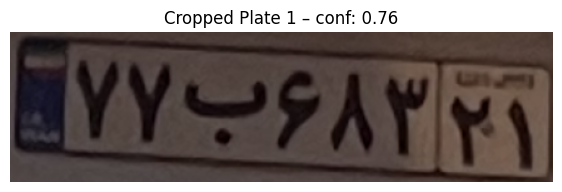

  Saved & shown: test8_plate1_conf0.76.jpg
  Raw OCR (words): sevensevenBsixeightthreetwotwo one
  Clean OCR (digits): sevensevenBsixeightthreetwotwo1
  (9 characters detected)
     → Renamed to: test8_plate1_sevensevenBsixeightthreetwotwo1.jpg

All processing finished!


In [11]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Fix for potential custom model loading issues
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])

# ================= CONFIG ==================
PLATE_DETECTOR_PATH  = "models/best.pt"          # Model for detecting whole plates
CHAR_OCR_PATH        = "models/plate.pt"         # Model for detecting/recognizing characters
CONF_THRESHOLD_PLATE = 0.70
CONF_THRESHOLD_CHAR  = 0.45                      # Usually lower for small characters

CROP_DIR             = Path("plate_crops")

# HARDCODED list of images to process
PLATE_IMAGES = [
    "photos/test8.jpg",
    # "photos/test2.jpg",
    # "photos/plate_iran_2025_001.jpg",
    # Add more paths here if needed
]
# ============================================


def load_models():
    """Load both detection models"""
    print("Loading models...")
    plate_detector = YOLO(PLATE_DETECTOR_PATH)
    char_ocr = YOLO(CHAR_OCR_PATH)
    print("Both models loaded successfully\n")
    return plate_detector, char_ocr


def word_to_digit(text: str) -> str:
    """
    Convert word-form numbers (one, two, seven...) to actual digits (1, 2, 7...)
    Add all your possible class names here
    """
    mapping = {
        'zero':  '0', 'one':   '1', 'two':   '2', 'three': '3', 'four':  '4',
        'five':  '5', 'six':   '6', 'seven': '7', 'eight': '8', 'nine':  '9',
        # Add letters as-is (they stay the same)
        'Alef': 'ا', 'Ayn': 'ع', 'B': 'ب', 'D': 'د', 'Gh': 'ق',
        'J': 'ج', 'L': 'ل', 'M': 'م', 'N': 'ن', 'Sad': 'ص',
        'Sin': 'س', 'Ta': 'ط', 'Te': 'ت', 'V': 'و',
        # Add any other class names your model uses
    }

    # Split by spaces, convert each word, join back
    words = text.split()
    result = ''.join(mapping.get(word.strip().lower(), word) for word in words)
    return result


def process_image(plate_detector, char_ocr, img_path: Path):
    """Process one image: detect plate → crop → detect characters → read text"""
    print(f"\n===== Processing: {img_path.name} =====")

    # 1. Detect license plates
    results = plate_detector(img_path, verbose=False)[0]
    img = cv2.imread(str(img_path))
    if img is None:
        print("Cannot read image")
        return

    good_plates = [b for b in results.boxes if float(b.conf) >= CONF_THRESHOLD_PLATE]

    if not good_plates:
        print("No license plates detected above threshold")
        return

    stem = img_path.stem

    for i, plate_box in enumerate(good_plates, 1):
        x1, y1, x2, y2 = map(int, plate_box.xyxy[0])
        conf = float(plate_box.conf)

        # Crop the plate
        crop = img[y1:y2, x1:x2]
        if crop.shape[0] < 30 or crop.shape[1] < 80:
            print(f"  Plate {i} too small → skipped")
            continue

        # Save & show cropped plate
        crop_name = f"{stem}_plate{i}_conf{conf:.2f}.jpg"
        crop_path = CROP_DIR / crop_name
        cv2.imwrite(str(crop_path), crop)

        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7, 4))
        plt.imshow(crop_rgb)
        plt.axis('off')
        plt.title(f"Cropped Plate {i} – conf: {conf:.2f}")
        plt.show()

        print(f"  Saved & shown: {crop_name}")

        # 2. Character detection on cropped plate
        char_results = char_ocr(crop_path, verbose=False)[0]

        characters = []
        for box in char_results.boxes:
            char_conf = float(box.conf)
            if char_conf < CONF_THRESHOLD_CHAR:
                continue

            cls_id = int(box.cls)
            char_name = char_ocr.names[cls_id]  # e.g. 'seven', 'B', 'one'...
            characters.append((box.xyxy[0], char_name, char_conf))

        if not characters:
            print("  No characters detected")
            continue

        # 3. Group by approximate row + sort
        rows = defaultdict(list)
        LINE_TOLERANCE_PX = 25  # adjust based on plate height

        for xyxy, char_name, conf in characters:
            x1c, y1c, x2c, y2c = map(int, xyxy)
            y_center = (y1c + y2c) / 2
            assigned = False
            for row_y in list(rows):
                if abs(y_center - row_y) < LINE_TOLERANCE_PX:
                    rows[row_y].append((xyxy, char_name, conf))
                    assigned = True
                    break
            if not assigned:
                rows[y_center] = [(xyxy, char_name, conf)]

        sorted_rows = sorted(rows.keys())  # top → bottom

        text_parts = []
        for row_y in sorted_rows:
            # LEFT-TO-RIGHT: reverse=False
            # RIGHT-TO-LEFT (Persian reading order): reverse=True
            row_sorted = sorted(rows[row_y], key=lambda t: t[0][0], reverse=False)
            row_text = ''.join(t[1] for t in row_sorted)
            if row_text:
                text_parts.append(row_text)

        raw_text = ' '.join(text_parts) if len(text_parts) > 1 else text_parts[0]

        # Convert word-form numbers to actual digits
        clean_text = word_to_digit(raw_text)

        print(f"  Raw OCR (words): {raw_text}")
        print(f"  Clean OCR (digits): {clean_text}")
        print(f"  ({len(characters)} characters detected)")

        # Optional: rename file with clean result
        try:
            new_name = f"{stem}_plate{i}_{clean_text.replace(' ', '_')}.jpg"
            new_path = CROP_DIR / new_name
            crop_path.rename(new_path)
            print(f"     → Renamed to: {new_name}")
        except Exception:
            pass


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES!")
        return

    plate_detector, char_ocr = load_models()

    print(f"Processing {len(PLATE_IMAGES)} images...\n")

    for img_str in PLATE_IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue
        process_image(plate_detector, char_ocr, img_path)

    print("\nAll processing finished!")


if __name__ == "__main__":
    main()

Loading models...
Models loaded successfully!

Processing 1 images...


===== Processing: test8.jpg =====


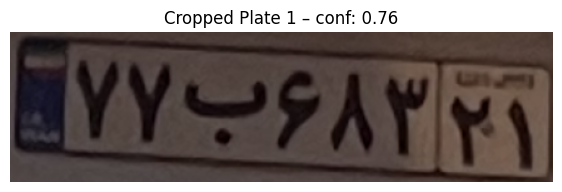

  Saved & shown: test8_plate1_conf0.76.jpg
  Raw OCR (words): sevensevenBsixeightthreetwotwo one
  Clean OCR (digits): 77ب68322 1
  (9 characters detected)
     → Renamed to: test8_plate1_77ب68322_1.jpg

All processing finished!


In [12]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Fix for potential custom model loading issues
torch.serialization.add_safe_globals(['ultralytics.nn.tasks.DetectionModel'])

# ================= CONFIG ==================
PLATE_DETECTOR_PATH  = "models/best.pt"          # Model that detects whole plates
CHAR_OCR_PATH        = "models/plate.pt"         # Model that detects individual characters
CONF_THRESHOLD_PLATE = 0.70
CONF_THRESHOLD_CHAR  = 0.45                      # Lower threshold for small characters

CROP_DIR             = Path("plate_crops")

# List of images to process
PLATE_IMAGES = [
    "photos/test8.jpg",
    # "photos/test2.jpg",
    # Add more paths here
]
# ============================================


def word_to_digit(raw_text: str) -> str:
    """
    Convert word-form numbers (one, two, seven...) to actual digits (1, 2, 7...)
    Keeps letters (like B) as they are.
    Works even when words are concatenated without spaces.
    """
    mapping = {
        'zero':  '0',
        'one':   '1',
        'two':   '2',
        'three': '3',
        'four':  '4',
        'five':  '5',
        'six':   '6',
        'seven': '7',
        'eight': '8',
        'nine':  '9',
        # Add your exact class names if they differ (case insensitive)
        # Letters stay the same
        'alef': 'ا', 'ayn': 'ع', 'b': 'ب', 'd': 'د', 'gh': 'ق',
        'j': 'ج', 'l': 'ل', 'm': 'م', 'n': 'ن', 'sad': 'ص',
        'sin': 'س', 'ta': 'ط', 'te': 'ت', 'v': 'و',
        # Add more if your model uses different naming
    }

    text = raw_text.lower()
    result = ''
    i = 0
    while i < len(text):
        matched = False
        # Try longest match first
        for word, digit in sorted(mapping.items(), key=lambda x: len(x[0]), reverse=True):
            if text[i:i+len(word)] == word:
                result += digit
                i += len(word)
                matched = True
                break
        if not matched:
            # Keep the character as-is (letter, space, etc.)
            result += text[i]
            i += 1

    return result


def load_models():
    """Load both YOLO models"""
    print("Loading models...")
    plate_detector = YOLO(PLATE_DETECTOR_PATH)
    char_ocr = YOLO(CHAR_OCR_PATH)
    print("Models loaded successfully!\n")
    return plate_detector, char_ocr


def process_image(plate_detector, char_ocr, img_path: Path):
    """Detect plate → crop → detect characters → convert to digits"""
    print(f"\n===== Processing: {img_path.name} =====")

    # 1. Detect license plates
    results = plate_detector(img_path, verbose=False)[0]
    img = cv2.imread(str(img_path))
    if img is None:
        print("Cannot read image")
        return

    good_plates = [b for b in results.boxes if float(b.conf) >= CONF_THRESHOLD_PLATE]

    if not good_plates:
        print("No license plates detected above threshold")
        return

    stem = img_path.stem

    for i, plate_box in enumerate(good_plates, 1):
        x1, y1, x2, y2 = map(int, plate_box.xyxy[0])
        conf = float(plate_box.conf)

        # Crop the plate
        crop = img[y1:y2, x1:x2]
        if crop.shape[0] < 30 or crop.shape[1] < 80:
            print(f"  Plate {i} too small → skipped")
            continue

        # Save & show cropped plate
        crop_name = f"{stem}_plate{i}_conf{conf:.2f}.jpg"
        crop_path = CROP_DIR / crop_name
        cv2.imwrite(str(crop_path), crop)

        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(7, 4))
        plt.imshow(crop_rgb)
        plt.axis('off')
        plt.title(f"Cropped Plate {i} – conf: {conf:.2f}")
        plt.show()

        print(f"  Saved & shown: {crop_name}")

        # 2. Character detection on cropped plate
        char_results = char_ocr(crop_path, verbose=False)[0]

        characters = []
        for box in char_results.boxes:
            char_conf = float(box.conf)
            if char_conf < CONF_THRESHOLD_CHAR:
                continue

            cls_id = int(box.cls)
            char_name = char_ocr.names[cls_id]  # e.g. 'seven', 'B', 'one'...
            characters.append((box.xyxy[0], char_name, char_conf))

        if not characters:
            print("  No characters detected")
            continue

        # 3. Group characters into rows + sort
        rows = defaultdict(list)
        LINE_TOLERANCE_PX = 25  # adjust based on your plate size

        for xyxy, char_name, conf in characters:
            x1c, y1c, x2c, y2c = map(int, xyxy)
            y_center = (y1c + y2c) / 2
            assigned = False
            for row_y in list(rows.keys()):
                if abs(y_center - row_y) < LINE_TOLERANCE_PX:
                    rows[row_y].append((xyxy, char_name, conf))
                    assigned = True
                    break
            if not assigned:
                rows[y_center] = [(xyxy, char_name, conf)]

        # Sort rows top → bottom
        sorted_rows = sorted(rows.keys())

        text_parts = []
        for row_y in sorted_rows:
            # LEFT-TO-RIGHT: reverse=False
            # RIGHT-TO-LEFT (Persian): reverse=True
            row_sorted = sorted(rows[row_y], key=lambda t: t[0][0], reverse=False)
            row_text = ''.join(t[1] for t in row_sorted)
            if row_text:
                text_parts.append(row_text)

        raw_text = ' '.join(text_parts) if len(text_parts) > 1 else text_parts[0]

        # Convert words to digits
        clean_text = word_to_digit(raw_text)

        print(f"  Raw OCR (words): {raw_text}")
        print(f"  Clean OCR (digits): {clean_text}")
        print(f"  ({len(characters)} characters detected)")

        # Optional: rename with clean result
        try:
            new_name = f"{stem}_plate{i}_{clean_text.replace(' ', '_')}.jpg"
            new_path = CROP_DIR / new_name
            crop_path.rename(new_path)
            print(f"     → Renamed to: {new_name}")
        except Exception:
            pass


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    if not PLATE_IMAGES:
        print("No images in PLATE_IMAGES!")
        return

    plate_detector, char_ocr = load_models()

    print(f"Processing {len(PLATE_IMAGES)} images...\n")

    for img_str in PLATE_IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found → {img_path}")
            continue
        process_image(plate_detector, char_ocr, img_path)

    print("\nAll processing finished!")


if __name__ == "__main__":
    main()

بارگذاری مدل‌ها...
مدل‌ها آماده


===== test8.jpg =====


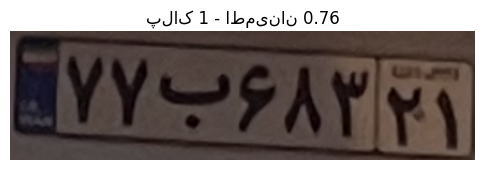

کراپ ذخیره و نمایش شد: test8_plate1_c75.jpg
  خروجی خام: onetwotwothreeeightsixBsevenseven
  خروجی نهایی: 122386B77
  (9 کاراکتر)
     → تغییر نام به: test8_plate1_122386B77.jpg

تموم شد!


In [18]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

# ================= تنظیمات ==================
PLATE_MODEL = "models/best.pt"       # مدل تشخیص پلاک
CHAR_MODEL  = "models/plate.pt"      # مدل تشخیص کاراکترها

CONF_PLATE = 0.70
CONF_CHAR  = 0.45

CROP_DIR = Path("plate_crops")

IMAGES = [
    "photos/test8.jpg",
    # بقیه عکس‌ها رو اینجا اضافه کن
]
# =============================================


# نقشه تبدیل کلمات به عدد/حرف
WORD_TO_CHAR = {
    'zero':  '0', 'one':   '1', 'two':   '2', 'three': '3', 'four':  '4',
    'five':  '5', 'six':   '6', 'seven': '7', 'eight': '8', 'nine':  '9',
    # حروف (اگر مدل شما این‌ها رو هم داره)
    'b':     'B', 'alef': 'ا', 'ayn': 'ع', 'd': 'د', 'gh': 'ق',
    'j':     'ج', 'l':    'ل', 'm':   'م', 'n':   'ن', 'sad': 'ص',
    'sin':   'س', 'ta':   'ط', 'te':  'ت', 'v':   'و',
}


def convert_words_to_digits(raw_text):
    """تبدیل کلمات به عدد/حرف - حتی اگر به هم چسبیده باشند"""
    text = raw_text.lower()
    result = []
    i = 0
    while i < len(text):
        matched = False
        for word, char in sorted(WORD_TO_CHAR.items(), key=lambda x: len(x[0]), reverse=True):
            if text.startswith(word, i):
                result.append(char)
                i += len(word)
                matched = True
                break
        if not matched:
            result.append(text[i])  # اگر حرف بود نگه دار
            i += 1
    return ''.join(result)


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    print("بارگذاری مدل‌ها...")
    plate_model = YOLO(PLATE_MODEL)
    char_model = YOLO(CHAR_MODEL)
    print("مدل‌ها آماده\n")

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"عکس پیدا نشد: {img_path}")
            continue

        print(f"\n===== {img_path.name} =====")

        # تشخیص پلاک
        results = plate_model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))
        if img is None:
            print("نمی‌تونم عکس رو بخونم")
            continue

        plates = [b for b in results.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("پلاکی پیدا نشد")
            continue

        for i, box in enumerate(plates, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 30 or crop.shape[1] < 80:
                print(f"پلاک {i} خیلی کوچیکه")
                continue

            # ذخیره و نمایش کراپ
            name = f"{img_path.stem}_plate{i}_c{int(conf*100)}.jpg"
            path = CROP_DIR / name
            cv2.imwrite(str(path), crop)

            plt.figure(figsize=(6, 4))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"پلاک {i} - اطمینان {conf:.2f}")
            plt.show()

            print(f"کراپ ذخیره و نمایش شد: {name}")

            # تشخیص کاراکترها
            char_res = char_model(path, verbose=False)[0]

            chars = []
            for b in char_res.boxes:
                if float(b.conf) < CONF_CHAR:
                    continue
                cls_name = char_res.names[int(b.cls)]
                chars.append((b.xyxy[0], cls_name))

            if not chars:
                print("  کاراکتری پیدا نشد")
                continue

            # مرتب‌سازی راست به چپ (x بزرگتر اول)
            sorted_chars = sorted(chars, key=lambda t: t[0][0], reverse=True)
            raw_text = ''.join(name for _, name in sorted_chars)

            # تبدیل به عدد واقعی
            final_text = convert_words_to_digits(raw_text)

            print(f"  خروجی خام: {raw_text}")
            print(f"  خروجی نهایی: {final_text}")
            print(f"  ({len(chars)} کاراکتر)")

            # تغییر نام فایل (اختیاری)
            try:
                new_name = f"{img_path.stem}_plate{i}_{final_text}.jpg"
                path.rename(CROP_DIR / new_name)
                print(f"     → تغییر نام به: {new_name}")
            except:
                pass

    print("\nتموم شد!")


if __name__ == "__main__":
    main()

بارگذاری مدل‌ها...

===== test8.jpg =====


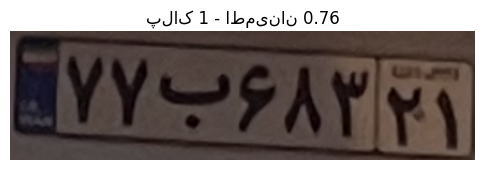

کراپ ذخیره شد: test8_plate1_c75.jpg
  خام: sevensevenBsixeightthreetwotwoone
  نهایی: 77b683221
  (9 کاراکتر)

===== test10.jpg =====

===== test11.jpg =====

===== test12.jpg =====

===== test13.jpg =====
عکس نیست: photos\test14.jpg

===== test15.jpg =====


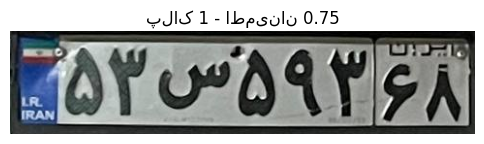

کراپ ذخیره شد: test15_plate1_c74.jpg
  خام: fiveJanbazfivethreesixeight
  نهایی: 5جaنbaz5368
  (6 کاراکتر)
     → تغییر نام: test15_plate1_5جaنbaz5368.jpg

===== test16.jpg =====

===== test17.jpg =====


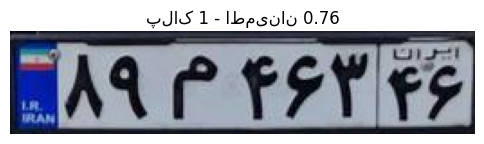

کراپ ذخیره شد: test17_plate1_c76.jpg
  خام: eightMfoursixthreefoursix
  نهایی: 8م46346
  (7 کاراکتر)
     → تغییر نام: test17_plate1_8م46346.jpg

تموم شد!


In [3]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

# تنظیمات
PLATE_MODEL = "models/best.pt"
CHAR_MODEL  = "models/plate.pt"

CONF_PLATE = 0.70
CONF_CHAR  = 0.45

CROP_DIR = Path("plate_crops")

IMAGES = [

    "photos/test8.jpg",
    "photos/test10.jpg",
    "photos/test11.jpg",
    "photos/test12.jpg",
    "photos/test13.jpg",
    "photos/test14.jpg",
    "photos/test15.jpg",
    "photos/test16.jpg",
    "photos/test17.jpg",




]  # بقیه رو اضافه کن

# نقشه کلمات به رقم/حرف
WORD_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'b': 'b', 'alef': 'ا', 'd': 'د', 'gh': 'ق', 'j': 'ج', 'l': 'ل',
    'm': 'م', 'n': 'ن', 'sad': 'ص', 'sin': 'س', 'ta': 'ط', 'te': 'ت', 'v': 'و'
}


def convert_to_digits(raw):
    text = raw.lower()
    result = []
    i = 0
    while i < len(text):
        matched = False
        for word, char in sorted(WORD_TO_CHAR.items(), key=lambda x: len(x[0]), reverse=True):
            if text.startswith(word, i):
                result.append(char)
                i += len(word)
                matched = True
                break
        if not matched:
            result.append(text[i])
            i += 1
    return ''.join(result)


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    print("بارگذاری مدل‌ها...")
    plate_model = YOLO(PLATE_MODEL)
    char_model = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"عکس نیست: {img_path}")
            continue

        print(f"\n===== {img_path.name} =====")

        # تشخیص پلاک
        results = plate_model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        plates = [b for b in results.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("پلاکی پیدا نشد")
            continue

        for i, box in enumerate(plates, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 30 or crop.shape[1] < 80:
                continue

            name = f"{img_path.stem}_plate{i}_c{int(conf*100)}.jpg"
            path = CROP_DIR / name
            cv2.imwrite(str(path), crop)

            plt.figure(figsize=(6, 4))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"پلاک {i} - اطمینان {conf:.2f}")
            plt.show()

            print(f"کراپ ذخیره شد: {name}")

            # تشخیص کاراکترها
            char_res = char_model(path, verbose=False)[0]

            chars = []
            for b in char_res.boxes:
                if float(b.conf) < CONF_CHAR:
                    continue
                name = char_res.names[int(b.cls)]
                chars.append((b.xyxy[0], name))

            if not chars:
                print("کاراکتری پیدا نشد")
                continue

            # مرتب‌سازی چپ به راست (x کوچک به بزرگ) ← این تغییر اصلی
            sorted_chars = sorted(chars, key=lambda t: t[0][0])  # reverse=False ← اینجا مهمه!

            raw_text = ''.join(name for _, name in sorted_chars)

            # تبدیل به عدد واقعی
            final = convert_to_digits(raw_text)

            print(f"  خام: {raw_text}")
            print(f"  نهایی: {final}")
            print(f"  ({len(chars)} کاراکتر)")

            # تغییر نام
            try:
                new_name = f"{img_path.stem}_plate{i}_{final}.jpg"
                path.rename(CROP_DIR / new_name)
                print(f"     → تغییر نام: {new_name}")
            except:
                pass

    print("\nتموم شد!")


if __name__ == "__main__":
    main()

بارگذاری مدل‌ها...

===== test8.jpg =====


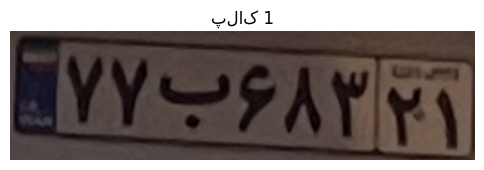

  خام: sevensevenBsixeightthreetwoone
  نهایی: 77b68321
  (8 کاراکتر)

تموم شد!


In [20]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

# تنظیمات
PLATE_MODEL = "models/best.pt"
CHAR_MODEL  = "models/plate.pt"

CONF_PLATE = 0.70
CONF_CHAR  = 0.45

CROP_DIR = Path("plate_crops")

IMAGES = ["photos/test8.jpg"]

# نقشه کلمات به رقم
WORD_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'b': 'b',  # اگر B بزرگ بود می‌تونی 'B':'B' بذاری
    # حروف دیگه رو اضافه کن اگر لازم بود
}


def convert_to_digits(raw):
    text = raw.lower()
    result = []
    i = 0
    while i < len(text):
        matched = False
        for word, char in sorted(WORD_TO_CHAR.items(), key=lambda x: len(x[0]), reverse=True):
            if text.startswith(word, i):
                result.append(char)
                i += len(word)
                matched = True
                break
        if not matched:
            result.append(text[i])
            i += 1
    final = ''.join(result)
    # حذف کاراکتر اضافی اگر بیشتر از ۸ تا شد
    if len(final) > 8:
        final = final[:8]
    return final


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    print("بارگذاری مدل‌ها...")
    plate_model = YOLO(PLATE_MODEL)
    char_model = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            continue

        print(f"\n===== {img_path.name} =====")

        results = plate_model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        plates = [b for b in results.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("پلاکی پیدا نشد")
            continue

        for i, box in enumerate(plates, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 30 or crop.shape[1] < 80:
                continue

            name = f"{img_path.stem}_plate{i}_c{int(conf*100)}.jpg"
            path = CROP_DIR / name
            cv2.imwrite(str(path), crop)

            plt.figure(figsize=(6, 4))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"پلاک {i}")
            plt.show()

            char_res = char_model(path, verbose=False)[0]

            chars = []
            for b in char_res.boxes:
                if float(b.conf) < CONF_CHAR:
                    continue
                name = char_res.names[int(b.cls)]
                chars.append((b.xyxy[0], name))

            if not chars:
                continue

            # مرتب‌سازی چپ به راست
            sorted_chars = sorted(chars, key=lambda t: t[0][0])

            # حذف کاراکترهای خیلی نزدیک (مثل تکراری)
            final_chars = []
            last_x = -1000
            for box, name in sorted_chars:
                curr_x = box[0]
                if curr_x - last_x > 15:  # حداقل فاصله ۱۵ پیکسل
                    final_chars.append(name)
                    last_x = curr_x

            raw = ''.join(final_chars)
            final = convert_to_digits(raw)

            print(f"  خام: {raw}")
            print(f"  نهایی: {final}")
            print(f"  ({len(final_chars)} کاراکتر)")

            try:
                new_name = f"{img_path.stem}_plate{i}_{final}.jpg"
                path.rename(CROP_DIR / new_name)
                print(f"     → تغییر نام: {new_name}")
            except:
                pass

    print("\nتموم شد!")


if __name__ == "__main__":
    main()

بارگذاری مدل‌ها...

===== test8.jpg =====


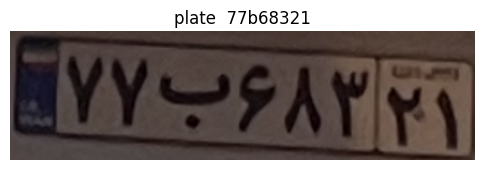

  خام: sevensevenBsixeightthreetwoone
  نهایی: 77b68321
  (8 کاراکتر)

===== test10.jpg =====

===== test11.jpg =====

===== test12.jpg =====

===== test13.jpg =====

===== test15.jpg =====


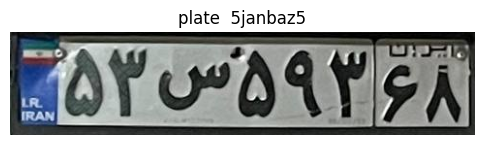

  خام: fiveJanbazfivethreesixeight
  نهایی: 5janbaz5
  (6 کاراکتر)

===== test16.jpg =====

===== test17.jpg =====


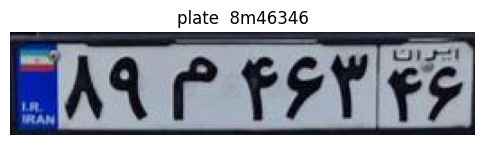

  خام: eightMfoursixthreefoursix
  نهایی: 8m46346
  (7 کاراکتر)

تموم شد!


In [6]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

# تنظیمات
PLATE_MODEL = "models/best.pt"
CHAR_MODEL  = "models/plate.pt"

CONF_PLATE = 0.70
CONF_CHAR  = 0.45

CROP_DIR = Path("plate_crops")

IMAGES = ["photos/test8.jpg",
    "photos/test10.jpg",
    "photos/test11.jpg",
    "photos/test12.jpg",
    "photos/test13.jpg",
    "photos/test14.jpg",
    "photos/test15.jpg",
    "photos/test16.jpg",
    "photos/test17.jpg",

]

# نقشه کلمات به رقم
WORD_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'b': 'b',  # اگر B بزرگ بود می‌تونی 'B':'B' بذاری
    # حروف دیگه رو اضافه کن اگر لازم بود
}


def convert_to_digits(raw):
    text = raw.lower()
    result = []
    i = 0
    while i < len(text):
        matched = False
        for word, char in sorted(WORD_TO_CHAR.items(), key=lambda x: len(x[0]), reverse=True):
            if text.startswith(word, i):
                result.append(char)
                i += len(word)
                matched = True
                break
        if not matched:
            result.append(text[i])
            i += 1
    final = ''.join(result)
    # حذف کاراکتر اضافی اگر بیشتر از ۸ تا شد
    if len(final) > 8:
        final = final[:8]
    return final


def main():
    CROP_DIR.mkdir(parents=True, exist_ok=True)

    print("بارگذاری مدل‌ها...")
    plate_model = YOLO(PLATE_MODEL)
    char_model = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            continue

        print(f"\n===== {img_path.name} =====")

        results = plate_model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        plates = [b for b in results.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("پلاکی پیدا نشد")
            continue

        for i, box in enumerate(plates, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 30 or crop.shape[1] < 80:
                continue

            name = f"{img_path.stem}_plate{i}_c{int(conf*100)}.jpg"
            path = CROP_DIR / name
            cv2.imwrite(str(path), crop)

            # plt.figure(figsize=(6, 4))
            # plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.title(f"plate")
            # plt.show()

            char_res = char_model(path, verbose=False)[0]

            chars = []
            for b in char_res.boxes:
                if float(b.conf) < CONF_CHAR:
                    continue
                name = char_res.names[int(b.cls)]
                chars.append((b.xyxy[0], name))

            if not chars:
                continue

            # مرتب‌سازی چپ به راست
            sorted_chars = sorted(chars, key=lambda t: t[0][0])

            # حذف کاراکترهای خیلی نزدیک (مثل تکراری)
            final_chars = []
            last_x = -1000
            for box, name in sorted_chars:
                curr_x = box[0]
                if curr_x - last_x > 15:  # حداقل فاصله ۱۵ پیکسل
                    final_chars.append(name)
                    last_x = curr_x

            raw = ''.join(final_chars)
            final = convert_to_digits(raw)



            plt.figure(figsize=(6, 4))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"plate  {final}")
            plt.show()

            print(f"  خام: {raw}")
            print(f"  نهایی: {final}")
            print(f"  ({len(final_chars)} کاراکتر)")

            try:
                new_name = f"{img_path.stem}_plate{i}_{final}.jpg"
                path.rename(CROP_DIR / new_name)
                print(f"     → تغییر نام: {new_name}")
            except:
                pass

    print("\nتموم شد!")


if __name__ == "__main__":
    main()

In [7]:
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path

# ────────────────────────────────────────────────
# تنظیمات پیشنهادی - اینا رو حتماً تست کن!
# ────────────────────────────────────────────────
CONF_PLATE = 0.65
CONF_CHAR  = 0.52      # خیلی مهم - بین 0.48 تا 0.62 تست کن
IOU_THRESHOLD = 0.45   # برای NMS اگر لازم شد

MIN_PLATE_HEIGHT = 35
MIN_PLATE_WIDTH  = 100

CROP_SIZE_FOR_CHAR_MODEL = (416, 160)  # اندازه‌ای که مدلت باهاش آموزش دیده

# کاراکترهای مجاز پلاک ایران (بسته به استان فرق داره)
VALID_CHARS = set("0123456789ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی")

# ────────────────────────────────────────────────

def preprocess_plate(crop):
    """بهبود کیفیت کراپ قبل از OCR"""
    # تبدیل به خاکستری
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

    # افزایش کنتراست
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # کمی sharpen
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)

    # کوچک کردن نویز
    denoised = cv2.fastNlMeansDenoising(sharpened, h=10)

    # resize با حفظ aspect ratio
    h, w = denoised.shape
    target_w, target_h = CROP_SIZE_FOR_CHAR_MODEL
    scale = min(target_w/w, target_h/h)
    new_w, new_h = int(w*scale), int(h*scale)
    resized = cv2.resize(denoised, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    # پد کردن تا اندازه دقیق
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    final = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    return cv2.cvtColor(final, cv2.COLOR_GRAY2BGR)  # مدل YOLO انتظار 3 کاناله داره


def get_center_x(box):
    x1, y1, x2, y2 = box
    return (x1 + x2) / 2


def main():
    plate_model = YOLO("models/best.pt")
    char_model  = YOLO("models/plate.pt")   # امیدوارم این مدل روی پلاک ایران آموزش دیده باشه!

    for img_path_str in IMAGES:
        img_path = Path(img_path_str)
        if not img_path.exists(): continue

        print(f"\n\n===== {img_path.name} =====")
        img = cv2.imread(str(img_path))
        if img is None: continue

        results = plate_model(img, verbose=False)[0]
        boxes = [b for b in results.boxes if float(b.conf) >= CONF_PLATE]

        for i, box in enumerate(boxes, 1):
            x1,y1,x2,y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < MIN_PLATE_HEIGHT or crop.shape[1] < MIN_PLATE_WIDTH:
                continue

            # پیش‌پردازش مهم!
            prepared_crop = preprocess_plate(crop)

            # ذخیره برای دیباگ (اختیاری)
            # cv2.imwrite(f"debug/prep_{img_path.stem}_{i}.jpg", prepared_crop)

            char_results = char_model(prepared_crop, verbose=False)[0]

            detections = []
            for b in char_results.boxes:
                if float(b.conf) < CONF_CHAR: continue
                cls_id = int(b.cls)
                name = char_results.names[cls_id]
                detections.append((b.xyxy[0], name, float(b.conf)))

            if not detections:
                print(f"  پلاک {i} → هیچ کاراکتری تشخیص داده نشد")
                continue

            # مرتب‌سازی بر اساس مرکز x
            sorted_dets = sorted(detections, key=lambda t: get_center_x(t[0]))

            # حذف تکراری‌های خیلی نزدیک
            final_chars = []
            last_x = -1000
            for box, name, conf in sorted_dets:
                cx = get_center_x(box)
                if cx - last_x > 12:  # این عدد رو هم باید تنظیم کنی
                    final_chars.append(name)
                    last_x = cx

            raw = ''.join(final_chars)

            # فیلتر کاراکترهای غیرمجاز + کوتاه کردن
            filtered = ''.join(c for c in raw if c in VALID_CHARS)
            final = filtered[:8]   # اکثر پلاک‌های ایران 7-8 رقم/حرف

            print(f"  پلاک {i}   conf:{conf:.3f}")
            print(f"  خام       : {raw}")
            print(f"  فیلتر شده : {final}   ({len(final)} کاراکتر)")

            # نمایش (اختیاری - برای دیباگ)
            # plt.figure(figsize=(12,5))
            # plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            # plt.title(f"{final}  | raw: {raw}")
            # plt.axis('off')
            # plt.show()

    print("\nپایان پردازش همه تصاویر")


if __name__ == "__main__":
    main()



===== test8.jpg =====
  پلاک 1   conf:0.773
  خام       : sevensevenBsixeighttwotwoone
  فیلتر شده :    (0 کاراکتر)


===== test10.jpg =====


===== test11.jpg =====


===== test12.jpg =====


===== test13.jpg =====


===== test15.jpg =====
  پلاک 1   conf:0.725
  خام       : fivefivetwosixeight
  فیلتر شده :    (0 کاراکتر)


===== test16.jpg =====


===== test17.jpg =====
  پلاک 1   conf:0.586
  خام       : eightsixtwofoursix
  فیلتر شده :    (0 کاراکتر)

پایان پردازش همه تصاویر
